# 🩺 GenECG-Diagnostic: YOLOv8 Training on T4 GPU

This notebook trains a **YOLOv8 model** to detect and classify **12 ECG leads** from standard 3x4 grid ECG images.

## 📋 Prerequisites
1. **Runtime**: Go to `Runtime → Change runtime type → T4 GPU`
2. **Data**: Your repo is synced via Google Drive Desktop

---

## 1️⃣ Verify GPU & Setup Environment

In [ ]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\n✅ PyTorch Version: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Thu Jan  1 04:49:53 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
# Install required packages
!pip install -q ultralytics
!pip install -q python-dotenv pyyaml tqdm

print("\n✅ Packages installed successfully!")


✅ Packages installed successfully!


## 2️⃣ Mount Google Drive (Synced from Mac)

In [24]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

# Path to your synced GenECG-Diagnostic folder
# (Synced from Mac via Google Drive Desktop)
PROJECT_ROOT = "/content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic"
!ls
import os
os.chdir(PROJECT_ROOT)
print(f"\n📁 Working directory: {os.getcwd()}")
!ls -la

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected

📁 Working directory: /content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic
total 6426
drwx------ 2 root root    4096 Dec 30 00:54 data
-rw------- 1 root root     544 Jan  1 04:03 data_A.yaml
-rw------- 1 root root      59 Dec 29 23:07 .env
-rw------- 1 root root    2093 Dec 30 01:05 GEMINI.md
drwx------ 2 root root    4096 Dec 30 01:56 .git
-rw------- 1 root root     325 Jan  1 03:57 .gitignore
drwx------ 2 root root    4096 Jan  1 04:21 notebooks
-rw------- 1 root root     434 Dec 29 22:53 README.md
-rw------- 1 root root     105 Dec 29 22:52 requirements.txt
drwx------ 2 root root    4096 Dec 30 02:06 runs
drwx------ 2 root root    4096 Dec 27 02:52 src
drwx------ 2 root root    4096 Dec 27 02:49 .venv
-rw------- 1 root root 6549796 Dec 30 02:06 yolov8n.pt


## 3️⃣ Verify Dataset Structure

In [25]:
from pathlib import Path

# Verify paths
data_yaml = Path("data_A.yaml")
images_root = Path("data/Raw/GenECG/Dataset_A_ECGs_without_imperfections")
labels_root = Path("data/Processed/YOLO_Labels/Dataset_A")

print("🔍 Verifying dataset structure...\n")

# Check YAML
if data_yaml.exists():
    print(f"✅ data_A.yaml found")
else:
    print(f"❌ data_A.yaml NOT found")

# Count images (handle bucket subdirectories)
images = list(images_root.rglob("*.png"))
print(f"📷 Images found: {len(images)}")

# Count labels
labels = list(labels_root.glob("*.txt"))
print(f"🏷️  Labels found: {len(labels)}")

# Sample verification
if images:
    sample_img = images[0]
    sample_size = sample_img.stat().st_size / 1024
    print(f"\n📄 Sample image: {sample_img.name} ({sample_size:.1f} KB)")
    if sample_size < 50:
        print("⚠️  WARNING: Small file size - may be a Git LFS pointer!")

if labels:
    sample_label = labels[0]
    print(f"📄 Sample label: {sample_label.name}")
    print(f"   Content preview:")
    with open(sample_label, 'r') as f:
        for line in f.readlines()[:3]:
            print(f"   {line.strip()}")

🔍 Verifying dataset structure...

✅ data_A.yaml found
📷 Images found: 21799
🏷️  Labels found: 21799

📄 Sample image: 20789_hr_1R.png (87.7 KB)
📄 Sample label: 20838_hr_1R.txt
   Content preview:
   0 0.125000 0.166667 0.225000 0.300000
   1 0.125000 0.500000 0.225000 0.300000
   2 0.125000 0.833333 0.225000 0.300000


## 4️⃣ Create YOLO-Compatible Dataset Structure

YOLO expects labels in `labels/` folder parallel to `images/`. We'll create the proper structure.

In [27]:
import shutil
from pathlib import Path
from tqdm import tqdm

# Create YOLO-compatible structure
YOLO_DATA = Path("data/yolo_dataset")
YOLO_IMAGES = YOLO_DATA / "images" / "train"
YOLO_LABELS = YOLO_DATA / "labels" / "train"

YOLO_IMAGES.mkdir(parents=True, exist_ok=True)
YOLO_LABELS.mkdir(parents=True, exist_ok=True)

# Source paths
SRC_IMAGES = Path("data/Raw/GenECG/Dataset_A_ECGs_without_imperfections")
SRC_LABELS = Path("data/Processed/YOLO_Labels/Dataset_A")

# Get all images with matching labels
all_images = list(SRC_IMAGES.rglob("*.png"))
print(f"📷 Total images available: {len(all_images)}")

# ⚡ LIMIT TO 500 FOR PROOF OF CONCEPT
MAX_SAMPLES = 500
matched_pairs = []
for img in all_images:
    label_path = SRC_LABELS / f"{img.stem}.txt"
    if label_path.exists():
        matched_pairs.append((img, label_path))
    if len(matched_pairs) >= MAX_SAMPLES:
        break

print(f"🔗 Using {len(matched_pairs)} image-label pairs (proof of concept)")

# Copy files
for img_path, label_path in tqdm(matched_pairs, desc="Copying dataset"):
    dest_img = YOLO_IMAGES / img_path.name
    dest_label = YOLO_LABELS / label_path.name

    if not dest_img.exists():
        shutil.copy2(img_path, dest_img)
    if not dest_label.exists():
        shutil.copy2(label_path, dest_label)

print(f"\n✅ Dataset prepared with {len(matched_pairs)} samples")

📷 Total images available: 21799
🔗 Using 500 image-label pairs (proof of concept)


Copying dataset: 100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


✅ Dataset prepared with 500 samples


In [28]:
# Create updated YAML for Colab training
colab_yaml_content = """# YOLO Dataset Configuration for Colab Training
# 12-Lead ECG Detection

path: data/yolo_dataset
train: images/train
val: images/train

nc: 12
names:
  0: Lead_I
  1: Lead_II
  2: Lead_III
  3: Lead_aVR
  4: Lead_aVL
  5: Lead_aVF
  6: Lead_V1
  7: Lead_V2
  8: Lead_V3
  9: Lead_V4
  10: Lead_V5
  11: Lead_V6
"""

with open("data_colab.yaml", "w") as f:
    f.write(colab_yaml_content)

print("✅ Created data_colab.yaml")

✅ Created data_colab.yaml


## 5️⃣ Train YOLOv8 Model 🚀

In [30]:
from ultralytics import YOLO

# Training Configuration
CONFIG = {
    'model': 'yolov8n.pt',
    'data': 'data_colab.yaml',
    'epochs': 50,
    'batch': 16,
    'imgsz': 640,
    'device': 0,
    'project': 'runs/detect',
    'name': 'genecg_colab',
    'exist_ok': True,
    'patience': 10,
    'save': True,
    'save_period': 5,
    'plots': True,
}

print("🚀 Training Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

🚀 Training Configuration:
   model: yolov8n.pt
   data: data_colab.yaml
   epochs: 50
   batch: 16
   imgsz: 640
   device: 0
   project: runs/detect
   name: genecg_colab
   exist_ok: True
   patience: 10
   save: True
   save_period: 5
   plots: True


In [31]:
# Initialize and train the model
model = YOLO(CONFIG['model'])

# Start training!
results = model.train(
    data=CONFIG['data'],
    epochs=CONFIG['epochs'],
    batch=CONFIG['batch'],
    imgsz=CONFIG['imgsz'],
    device=CONFIG['device'],
    project=CONFIG['project'],
    name=CONFIG['name'],
    exist_ok=CONFIG['exist_ok'],
    patience=CONFIG['patience'],
    save=CONFIG['save'],
    save_period=CONFIG['save_period'],
    plots=CONFIG['plots'],
)

Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=genecg_colab, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretra

## 6️⃣ View Training Results

📈 Training Curves:


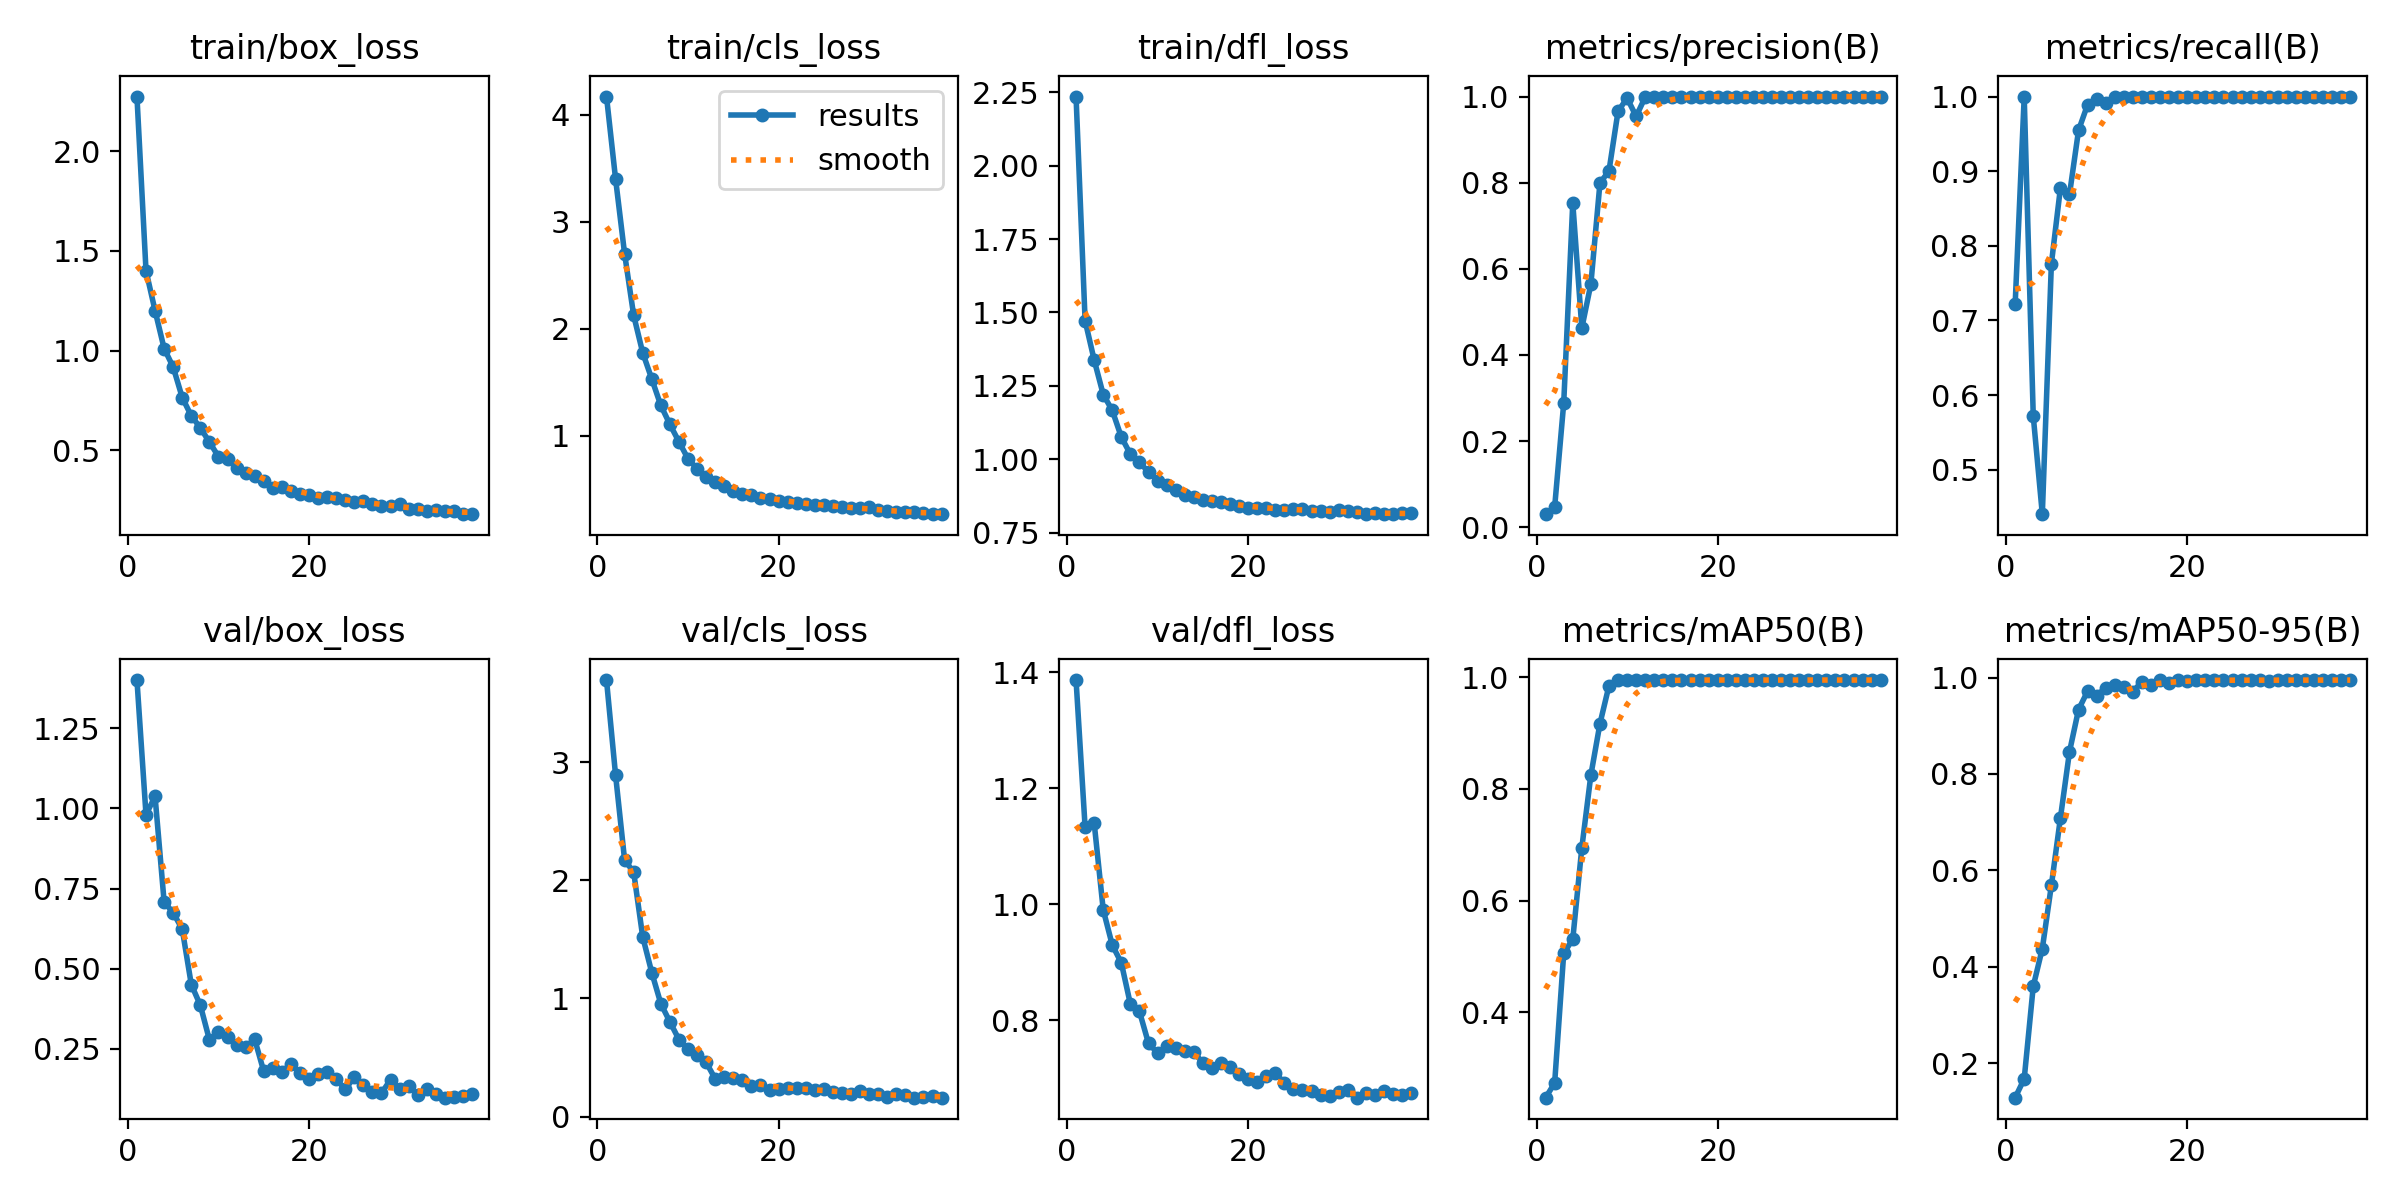


📊 Confusion Matrix:


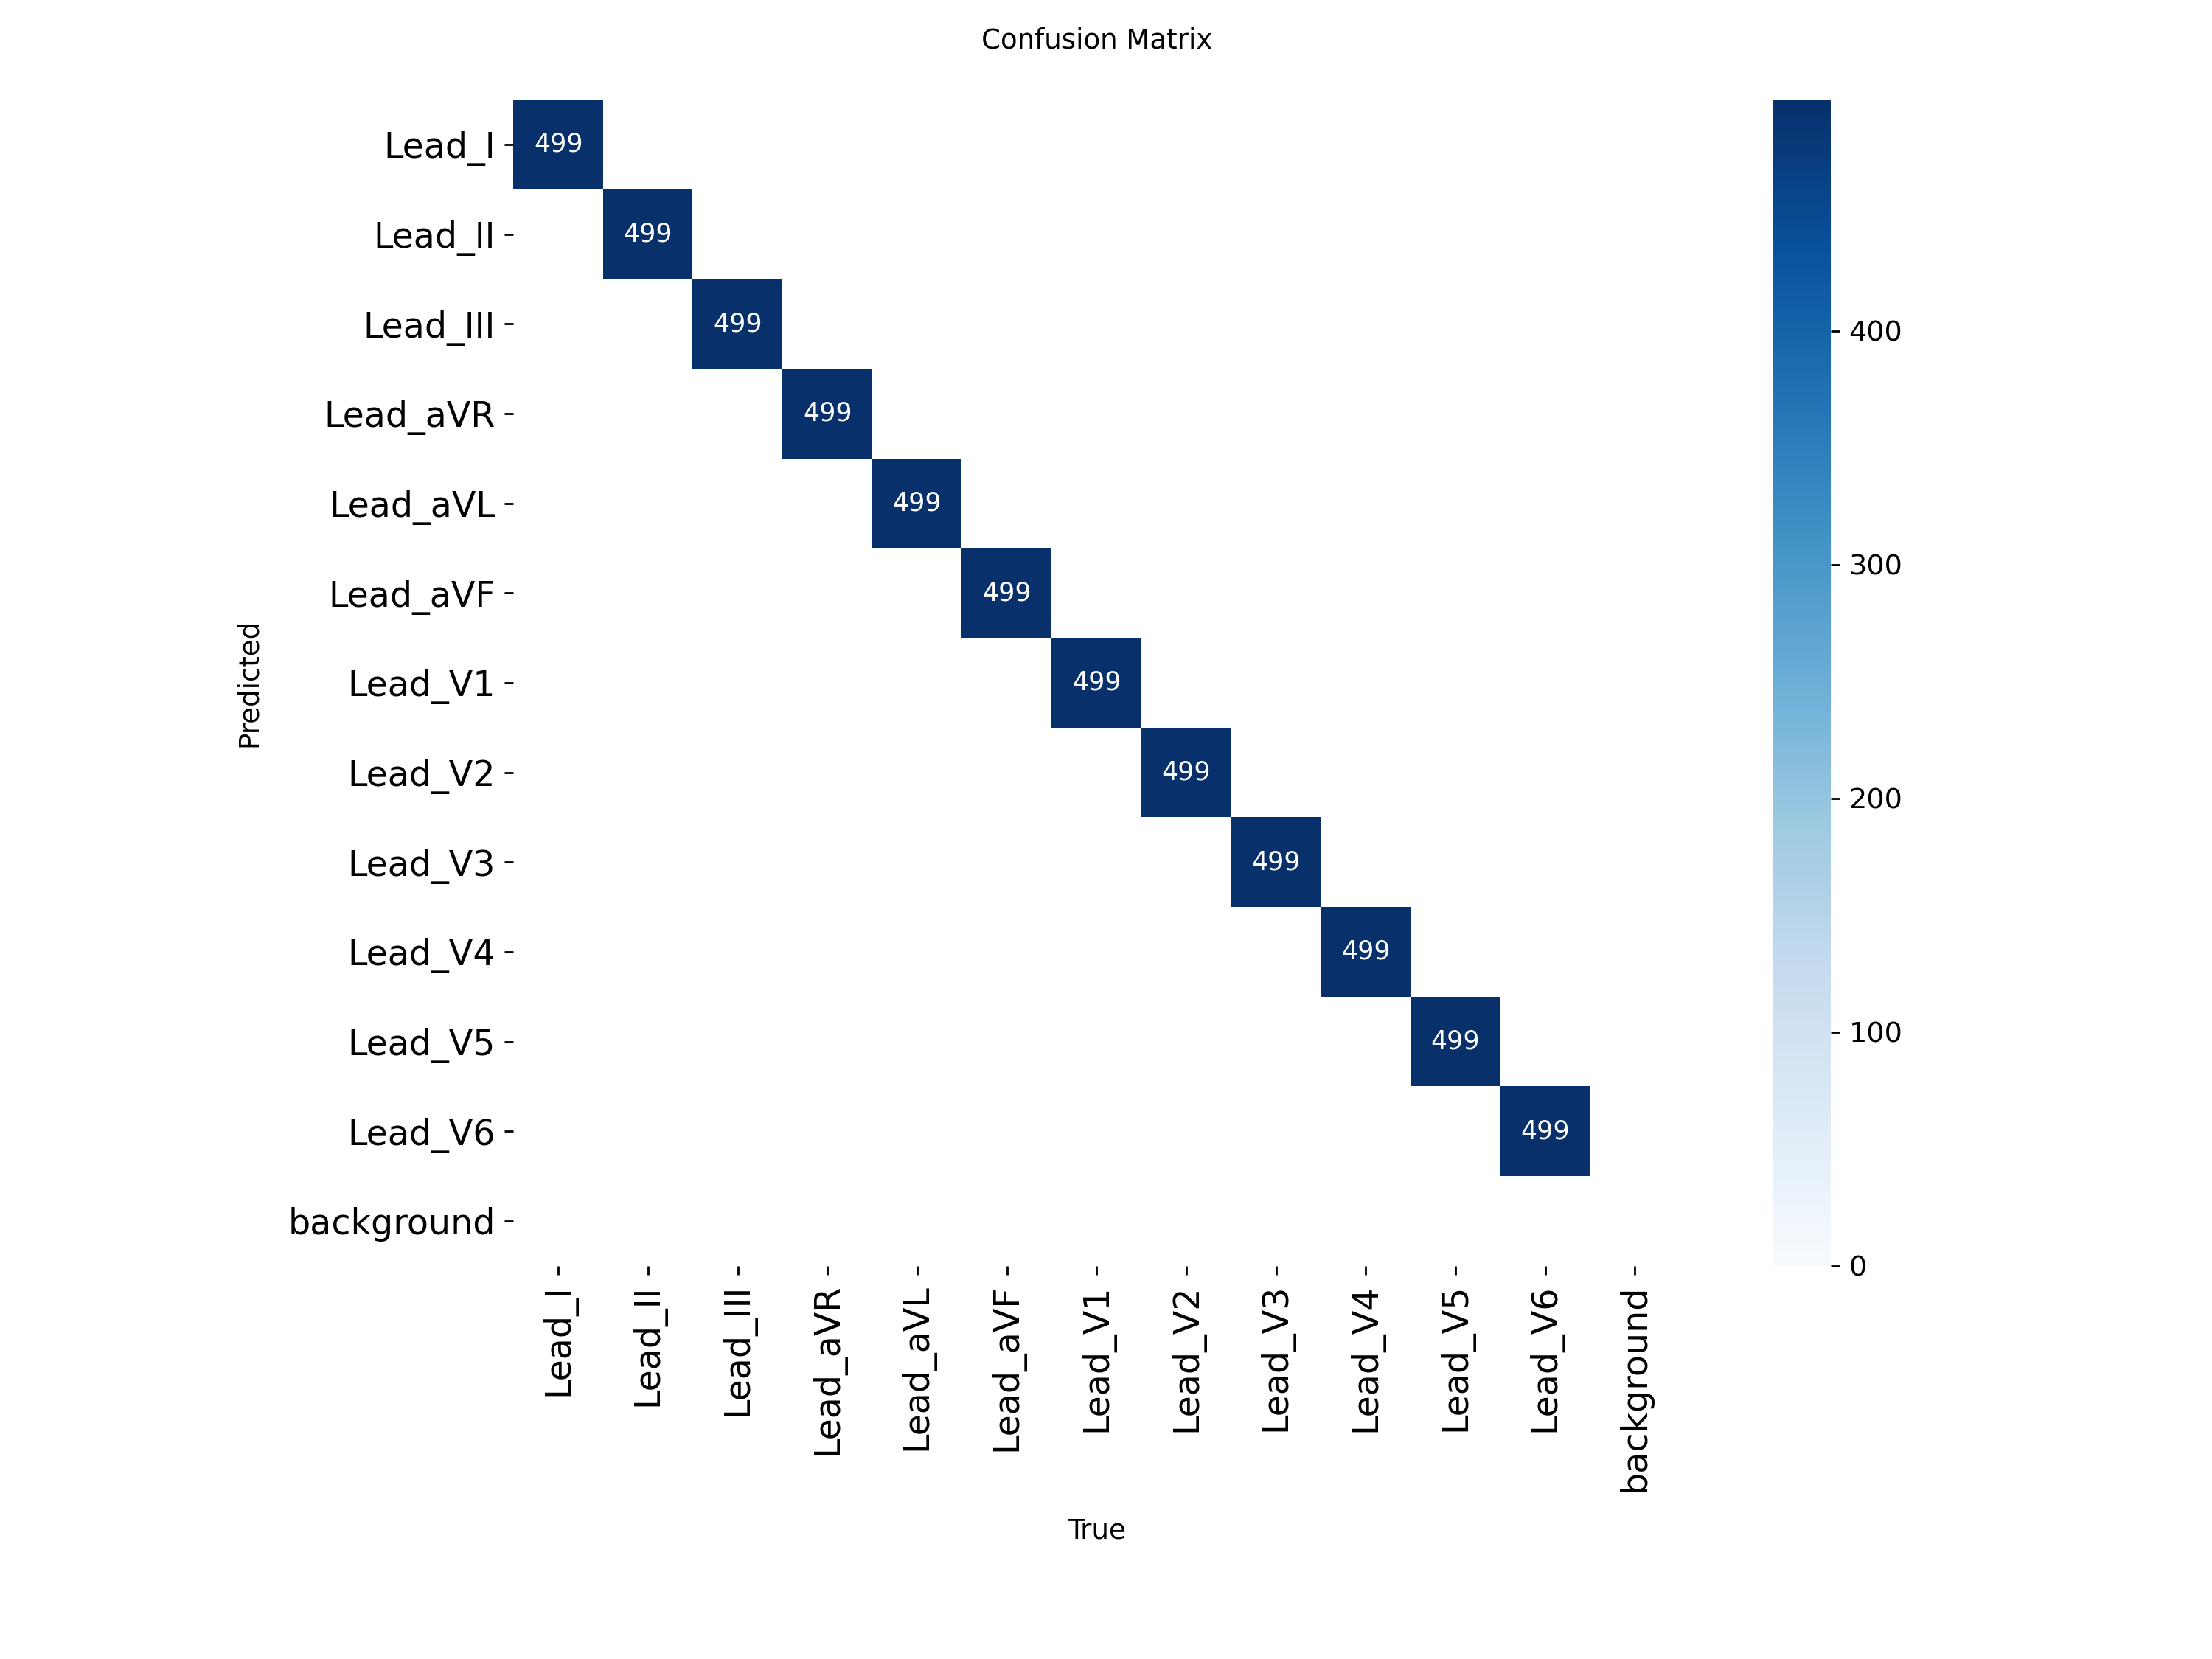


🎯 Sample Predictions:


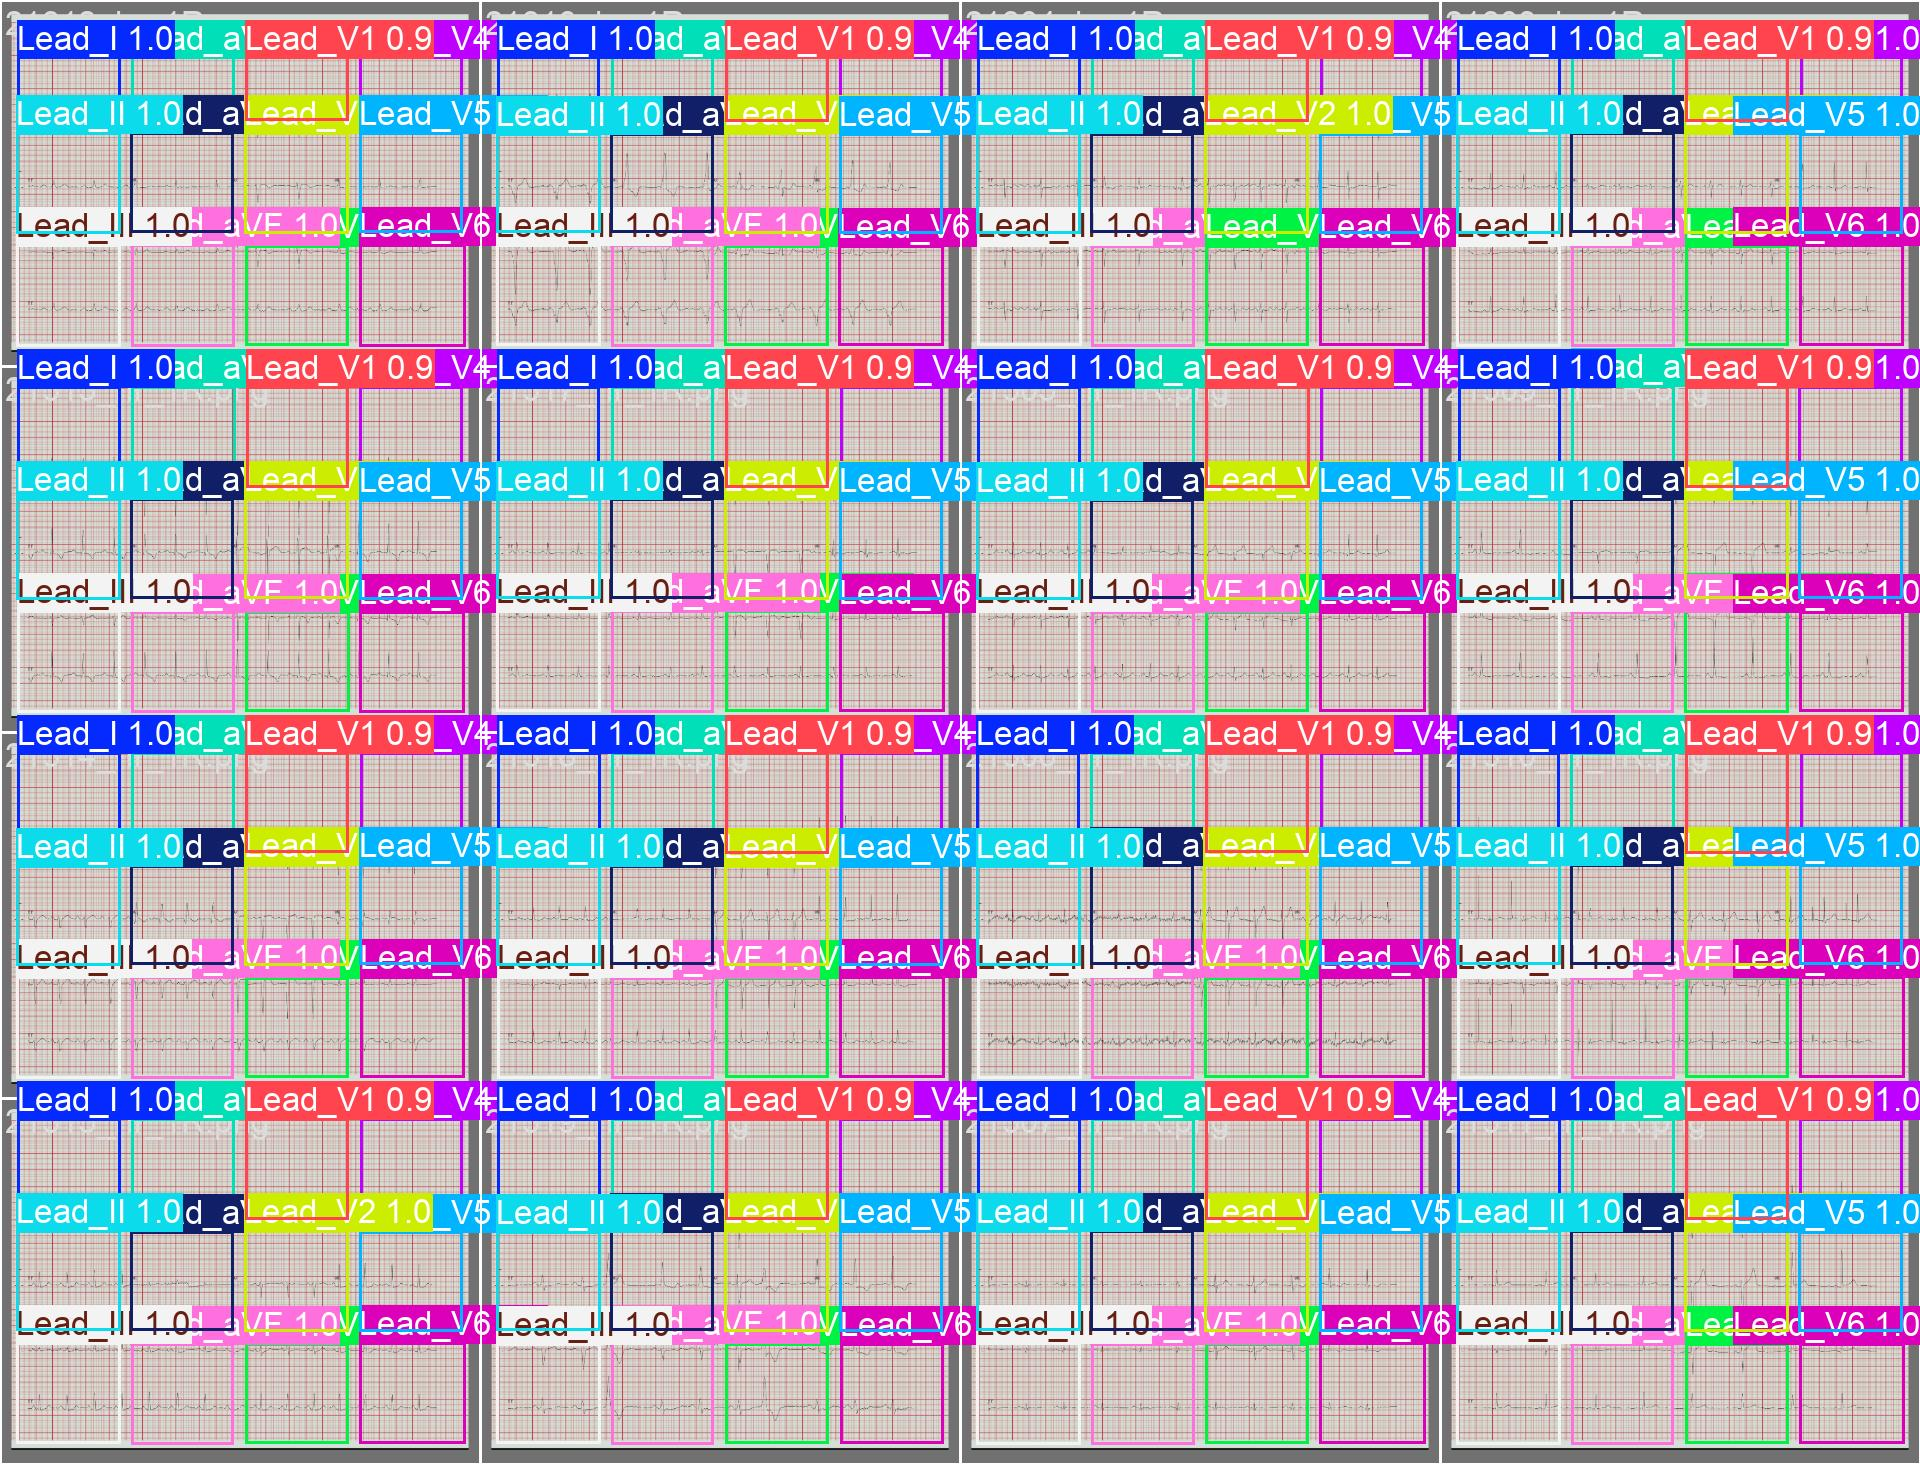

In [32]:
from IPython.display import Image, display
from pathlib import Path

train_dir = Path(f"{CONFIG['project']}/{CONFIG['name']}")

# Display training curves
results_img = train_dir / "results.png"
if results_img.exists():
    print("📈 Training Curves:")
    display(Image(filename=str(results_img), width=800))

# Display confusion matrix
confusion_img = train_dir / "confusion_matrix.png"
if confusion_img.exists():
    print("\n📊 Confusion Matrix:")
    display(Image(filename=str(confusion_img), width=600))

# Display sample predictions
val_batch_img = train_dir / "val_batch0_pred.jpg"
if val_batch_img.exists():
    print("\n🎯 Sample Predictions:")
    display(Image(filename=str(val_batch_img), width=800))

## 7️⃣ Test the Trained Model

In [33]:
# Load the best model
best_model_path = train_dir / "weights" / "best.pt"

if best_model_path.exists():
    print(f"✅ Loading best model from: {best_model_path}")
    trained_model = YOLO(str(best_model_path))

    # Run inference on sample images
    sample_images = list(Path("data/yolo_dataset/images/train").glob("*.png"))[:5]

    if sample_images:
        print(f"\n🔍 Running inference on {len(sample_images)} samples...")
        results = trained_model.predict(
            source=sample_images,
            save=True,
            project="runs/detect",
            name="inference_test",
            exist_ok=True,
            conf=0.25,
        )
        print("✅ Inference complete!")

✅ Loading best model from: runs/detect/genecg_colab/weights/best.pt

🔍 Running inference on 5 samples...

0: 480x640 1 Lead_I, 2 Lead_IIs, 1 Lead_III, 1 Lead_aVR, 1 Lead_aVL, 1 Lead_aVF, 1 Lead_V1, 1 Lead_V2, 2 Lead_V3s, 1 Lead_V4, 1 Lead_V5, 2 Lead_V6s, 12.2ms
1: 480x640 1 Lead_I, 2 Lead_IIs, 1 Lead_III, 1 Lead_aVR, 1 Lead_aVL, 1 Lead_aVF, 1 Lead_V1, 1 Lead_V2, 1 Lead_V3, 1 Lead_V4, 1 Lead_V5, 1 Lead_V6, 12.2ms
2: 480x640 1 Lead_I, 1 Lead_II, 1 Lead_III, 1 Lead_aVR, 1 Lead_aVL, 1 Lead_aVF, 1 Lead_V1, 1 Lead_V2, 1 Lead_V3, 1 Lead_V4, 1 Lead_V5, 2 Lead_V6s, 12.2ms
3: 480x640 3 Lead_IIs, 1 Lead_III, 1 Lead_aVR, 1 Lead_aVL, 1 Lead_aVF, 1 Lead_V1, 1 Lead_V2, 1 Lead_V3, 1 Lead_V4, 1 Lead_V5, 3 Lead_V6s, 12.2ms
4: 480x640 1 Lead_I, 2 Lead_IIs, 1 Lead_III, 1 Lead_aVR, 1 Lead_aVL, 1 Lead_aVF, 1 Lead_V1, 1 Lead_V2, 1 Lead_V3, 1 Lead_V4, 1 Lead_V5, 2 Lead_V6s, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/drive/O

## 8️⃣ Export Model

In [34]:
# Export to ONNX
if best_model_path.exists():
    trained_model = YOLO(str(best_model_path))
    print("📦 Exporting to ONNX...")
    trained_model.export(format='onnx', dynamic=True)
    print("✅ Export complete!")

    # List weights
    weights_dir = train_dir / "weights"
    print(f"\n📁 Saved weights:")
    for f in weights_dir.glob("*"):
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"   {f.name} ({size_mb:.2f} MB)")

📦 Exporting to ONNX...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/genecg_colab/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 16, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 146ms
Prepared 6 packages in 8.63s
Installed 6 packages in 264ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.81

requirements: AutoUpdate success ✅ 9.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effe

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.81...
ONNX: export success ✅ 13.4s, saved as 'runs/detect/genecg_colab/weights/best.onnx' (11.8 MB)

Export complete (13.8s)
Results saved to /content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic/runs/detect/genecg_colab/weights
Predict:         yolo predict task=detect model=runs/detect/genecg_colab/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/genecg_colab/weights/best.onnx imgsz=640 data=data_colab.yaml  
Visualize:       https://netron.app
✅ Export complete!

📁 Saved weights:
   last.pt (5.95 MB)
   best.pt (5.95 MB)
   epoch0.pt (17.61 MB)
   epoch5.pt (17.61 MB)
   epoch10.pt (17.61 MB)
   epoch15.pt (17.61 MB)
   epoch20.pt (17.61 MB)
   epoch25.pt (17.61 MB)
   epoch30.pt (17.61 MB)
   epoch35.pt (17.62 MB)
   best.onnx (11.77 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
## ✅ Done!

Your trained model is saved at `runs/detect/genecg_colab/weights/best.pt`

Since you're using Google Drive sync, the model will automatically sync back to your Mac!